# MLP

Using normalization did not yield satisfying results (converged at ~57), next trials are by only minimizing some of the data, adding more prepocessed data, and adding array data for the following days technical indicators


Train with a variety of indicators to see which yield the most promising results, easiest approach normalize data between 0-1 and replace one row, then recalculate accuracy and do backtesting https://medium.datadriveninvestor.com/a-simple-way-to-know-how-important-your-input-is-in-neural-network-86cbae0d3689
 - Download Backtesting library
 - Normalize Data properly (somehow)

Try maybe Garsons algorithm

Check out PyCaret - https://pycaret.org/normalization/

Get Started on Trading algorithm, use 7 day forecast for stock selection, etc. etc.

## Best model as returned from Hyperparameter tuning

For this the data was preped using ModDataset and then undersampled, this data was then fed to the Hyperband tuner and after 12 hours it was interrupted and the best model was used for this analysis

There are still flaws to be fixed, i.e. the data was non_normalized

In [9]:
%matplotlib inline
import sys
sys.path.append('..')
import numpy as np
from keras_tuner import Hyperband
from OptimizeNN_keras import MultiLayerPerceptron
from eval_network import Eval_Model
from Raw_Data import ModDataset
import datetime as dt
import matplotlib.pyplot as plt

## Retrieve the model

In [5]:

tuner = Hyperband(
    hypermodel = MultiLayerPerceptron,
    max_epochs=1000, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
    objective="accuracy", 
    factor=5,
    hyperband_iterations=2, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
    directory='/home/felix/NeuralNetworks/MLP_SP_under',
    project_name= 'MLP_SP_under'
)
tuner.reload()

INFO:tensorflow:Reloading Oracle from existing project /home/felix/NeuralNetworks/MLP_SP_under/MLP_SP_under/oracle.json
INFO:tensorflow:Reloading Tuner from /home/felix/NeuralNetworks/MLP_SP_under/MLP_SP_under/tuner0.json


In [6]:
params = tuner.get_best_hyperparameters(num_trials=1)[0].get_config()['values']
for key in params.keys():
    print(key, ' : ', params[key])
model = tuner.get_best_models()[0]

Dense1  :  12
Dense2  :  17
Dense3  :  10
learning rate  :  0.01
epsilon  :  0.0001
tuner/epochs  :  1000
tuner/initial_epoch  :  200
tuner/bracket  :  4
tuner/round  :  4
tuner/trial_id  :  e5c2d4160523a64cfbf8489e3e5521a2


## First lets visualize how the Model places its buys holds and sells

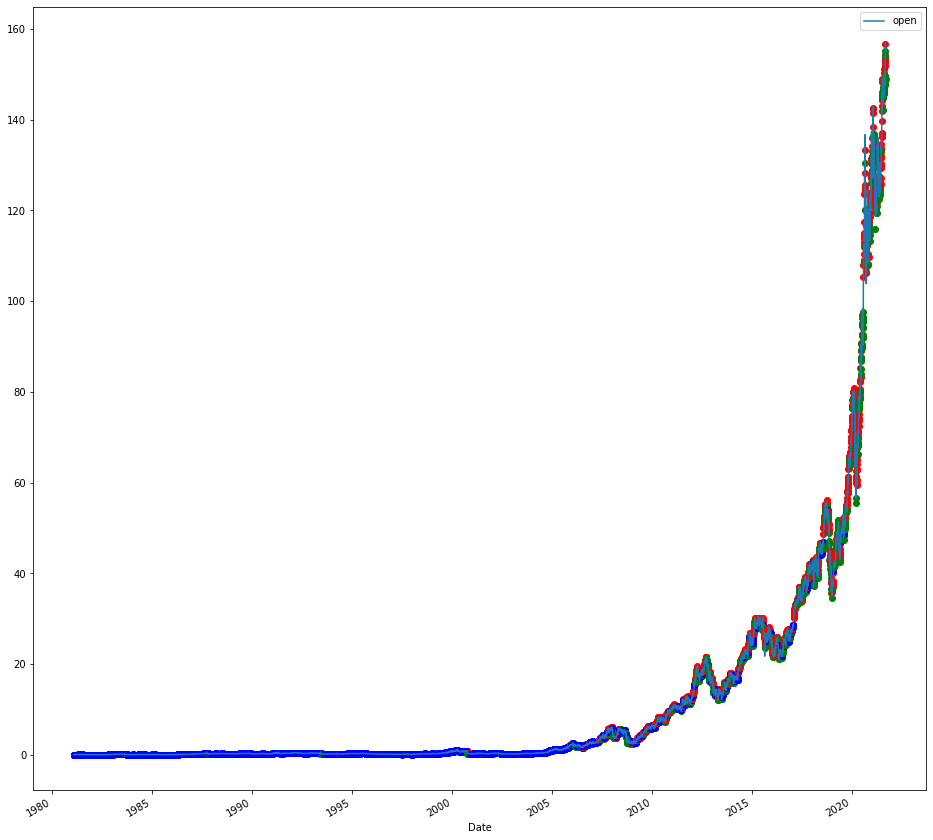

In [10]:
import datetime as dt
import matplotlib.pyplot as plt
# Get Dataset for Apple
test_data = ModDataset('/home/felix/MLP_stockdata/yf_AAPL.pkl')
#Prepare for plotting
test_data.data['Date']=test_data.data['Date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%dT00:00:00.000000000'))
#Make predictions
pred = model.predict(test_data.data.iloc[::,6:-3].to_numpy())
#Quick helper function
def get_index(arr):
    for i in range(len(arr)):
        if arr[i] >= 0.5:
            arr[i] = 1
        else:
            arr[i] = 0
    res = np.sum(arr*[1,2,3])
    if res == 0:
        return 1 #Return hold in case of undetermined
    else:
        return res
#Get plotting
test_data.data.plot(x='Date',y='open', figsize=(16,16))
for i in range(len(pred)):
    decision= get_index(pred[i]) #1Buy 2Hold 3Sell
    if decision==1: c='g'
    if decision==2: c='b'
    if decision==3: c='r'
    plt.scatter(test_data.data.loc[::,'Date'].iloc[i], test_data.data.loc[::,'close'].iloc[i],c=c)

## Now lets plot the annualized performance on the different stocks

In [11]:
evaluator = Eval_Model(model, '/home/felix/MLP_stockdata/')
evaluator.compute()

mean  ±  std: 555.9427071222165 ± 2406.974325526195
median 68.62908068304476
Ignoring the top 50 results
mean  ±  std: 120.31490565102077 ± 158.7274549962104
median 57.480194039717105


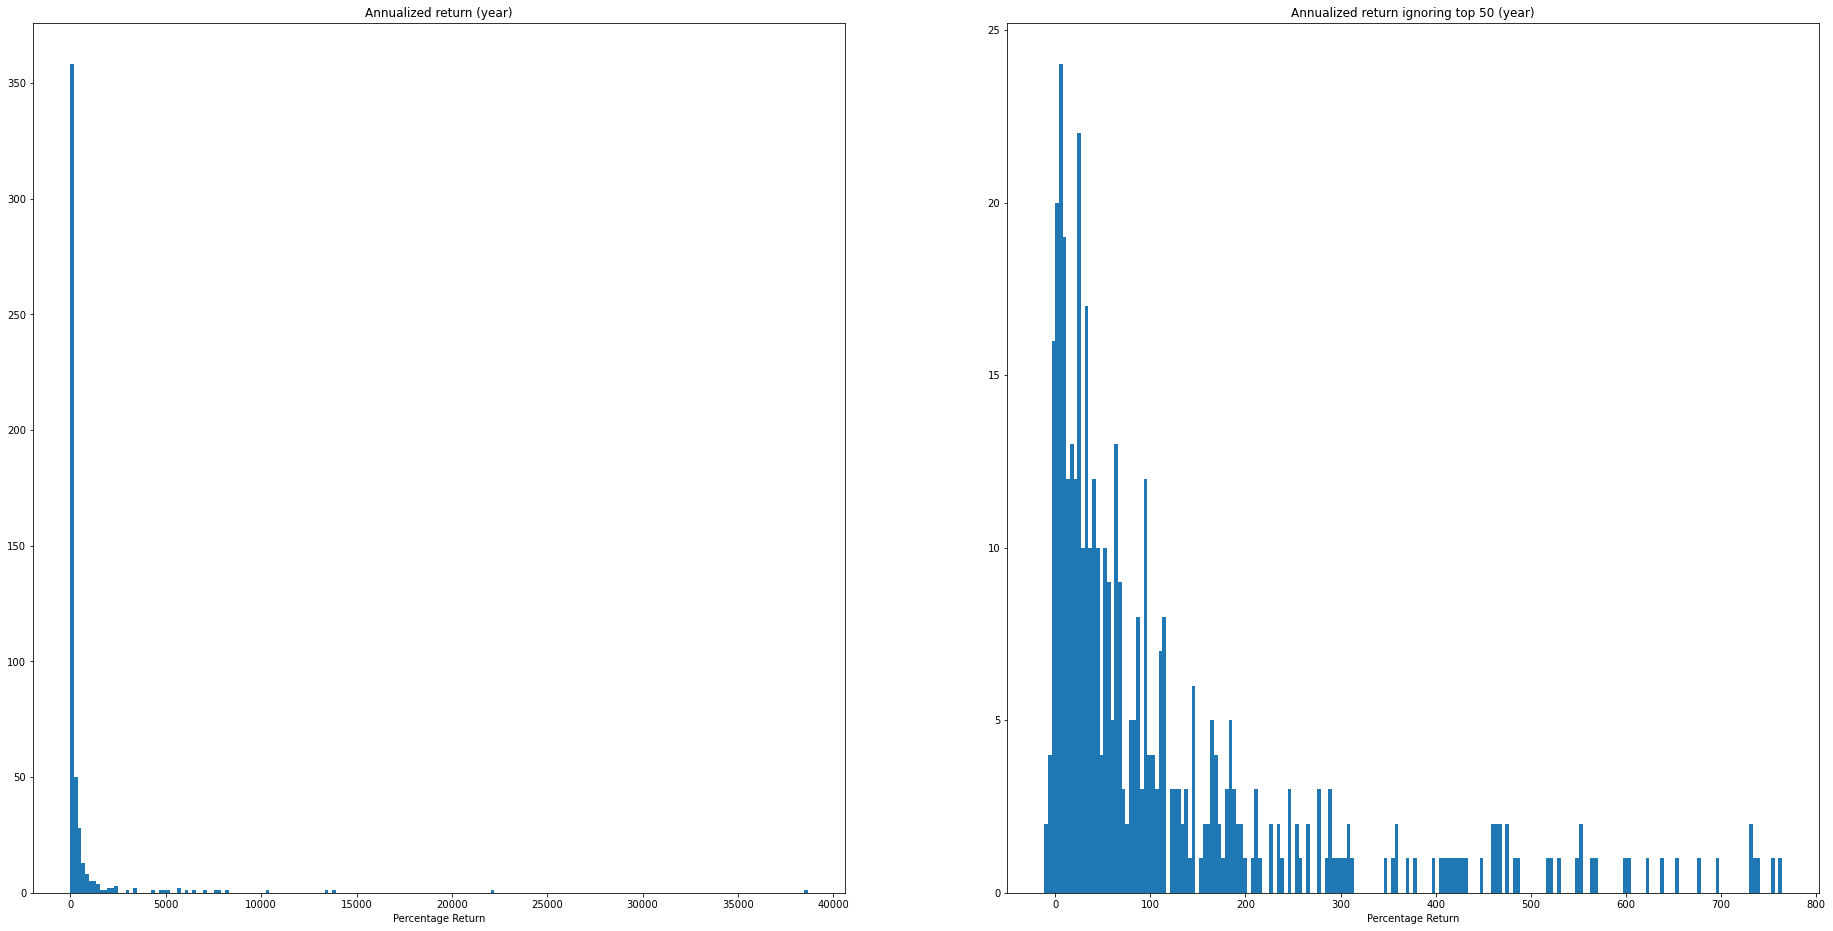

In [12]:
evaluator.make_plot(year=True)

mean  ±  std: 1.5231307044444284 ± 6.594450206921083
median 0.18802487858368427
Ignoring the top 50 results
mean  ±  std: 0.3296298784959473 ± 0.43486973971564497
median 0.1574799836704578


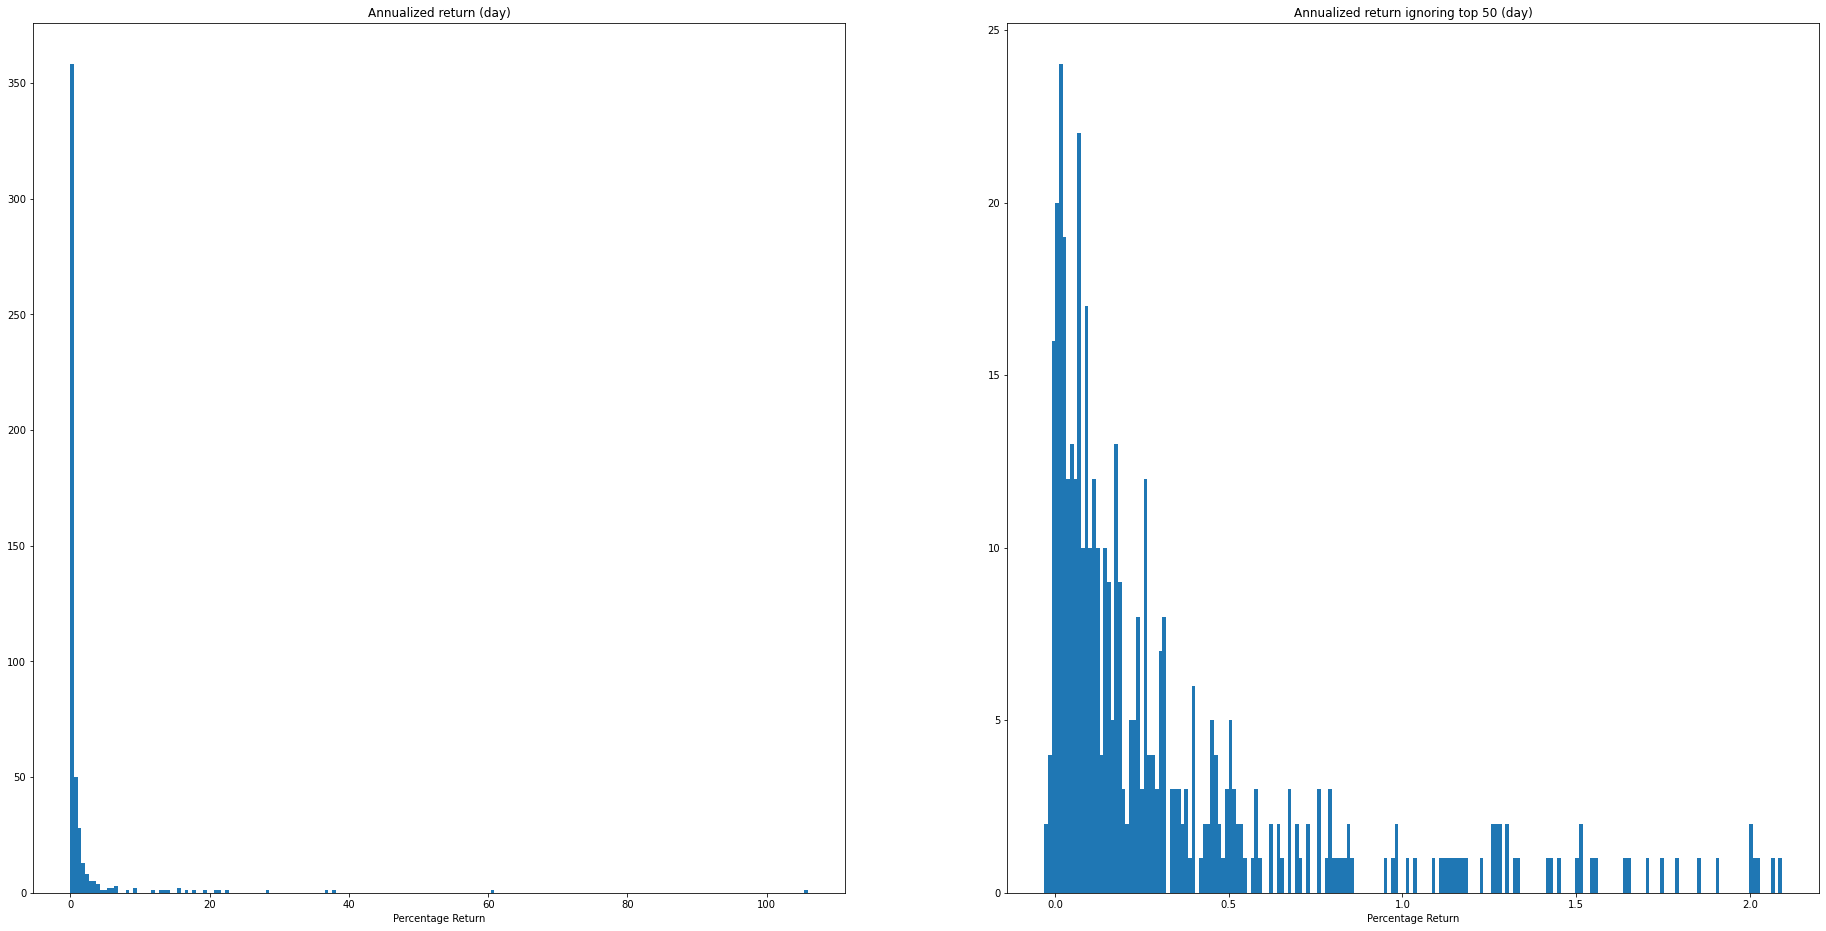

In [13]:
evaluator.make_plot(day=True)

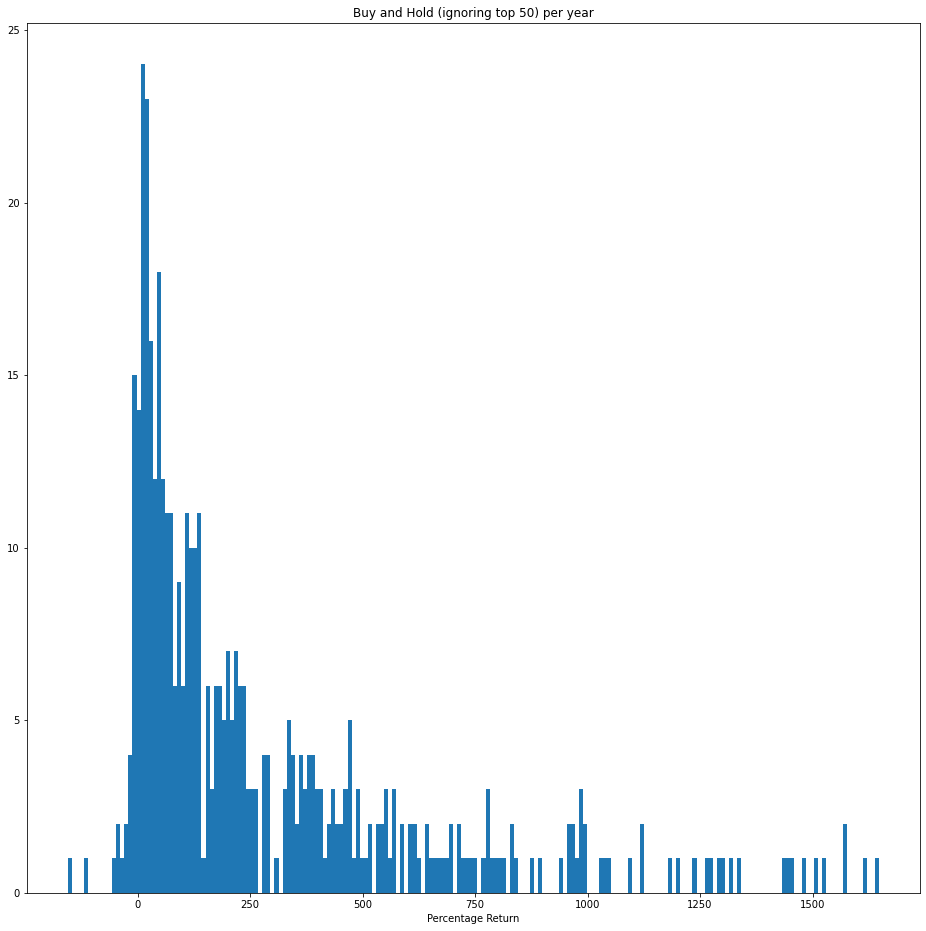

In [14]:
evaluator.buy_and_hold_plot()

Above we find 6 graphs, the first two represent the annualized profits per year for all stocks in the SP500 and the annualized profits per year excluding the top 50 performers.
The third and forth represent the same data but annualized per day.
And the last two represent purchasing the stock on the day they came out and then selling them on the most recent data point

One thing to keep in mind when viewing the last plots, is that these are the best performing stocks in the US, so Buy and Hold will on average yield lower results (If im not mistaken, I very well could be)

Also note that the network has less performers in the negative range.

I will have to double check this as there shouldnt be any performers in the negative range for Buy and Hold as all stocks in the SP500 should be far above opening price

## Now to focus on the neural network itself rather than its performance on stocks

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

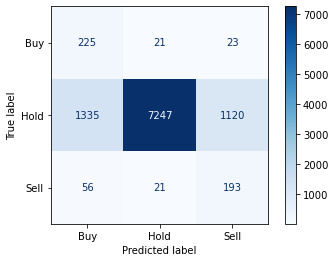

In [23]:
#Using the prediction made earlier
y_pred = np.array([get_index(i) for i in pred])
#Get data
y_act = test_data.data.iloc[::,-3::].to_numpy()
#Create identifiers
y_act = np.array([np.sum(i*[1,2,3]) for i in y_act])

labels = ["Buy", "Hold", "Sell"]

cm = confusion_matrix(y_act, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

The confusion matrix is not to be taken as definite of wheter or not the sell or hold position was appropriate as the labels came from a scipy function to determine peaks which was subsequently maximized for profits (It can be found under Raw_Data in class ModDataset under function find_peaks)